### **Ứng Dụng Khai Thác Dữ Liệu Trong Việc Dự Báo Phân Bổ Hàng Hóa Bán Lẻ**

## Tổng quan và mục tiêu

Thông qua khả năng kết nối Doris với Spark, chúng ta có thể tiếp tục ứng dụng khai thác dữ liệu trong quản lý tồn kho tại các cửa hàng bán lẻ. Bằng cách sử dụng các kỹ thuật học máy cả không giám sát và có giám sát để giải quyết hai bài toán chính, nhóm đưa ra phân tích tình hình kinh doanh hiện tại và dự báo việc phân bổ hàng hóa một cách hợp lý, góp phần tối ưu doanh thu cho cửa hàng.

## Kỹ thuật được sử dụng
1.  **Gom cụm (Clustering) bằng K-Means**: Sử dụng thuật toán K-Means để phân nhóm các sản phẩm có đặc điểm tương đồng (như giá cả, nhu cầu, khuyến mãi), từ đó xác định các chiến lược kinh doanh phù hợp cho từng nhóm sản phẩm.

# 1. Cài đặt thư viện


Tiến hành cài đặt các thư viện cần thiết cho quá trình phân tích và khai thác dữ liệu


In [33]:
# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [34]:
import mysql.connector
from mysql.connector import Error

# 2. Kết nối Apache Doris


In [35]:
# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("RetailDataMining") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

# Thiết lập log level để giảm output
spark.sparkContext.setLogLevel("WARN")

print("✅ SparkSession đã được khởi tạo thành công!")

✅ SparkSession đã được khởi tạo thành công!


In [36]:
from sqlalchemy import create_engine, text

# Cấu hình kết nối SQLAlchemy tới Doris (MySQL-compatible)
username = "root"
password = ""
host = "127.0.0.1"
port = 9030
database = "retail_db"

# Tạo engine SQLAlchemy
engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}")


if engine.connect():
    print("✅ Kết nối Apache Doris thành công!")

✅ Kết nối Apache Doris thành công!


# 3. Chuẩn bị dữ liệu


Chuẩn bị và tải dữ liệu sử dụng để thực hiện phân tích.


In [37]:
# Đọc dữ liệu từ bảng sales
import pandas as pd

query = "SELECT * FROM sales"
df_pandas = pd.read_sql(query, engine)

df = spark.createDataFrame(df_pandas)

print("📊 Thông tin dữ liệu từ Doris:")
df.show(5)
df.printSchema()
    
# Đếm tổng số dòng trong bảng
total_count = df.count()
print(f"📈 Tổng số record trong bảng sales: {total_count}")

📊 Thông tin dữ liệu từ Doris:
+----------+--------+----------+-----------+------+---------------+----------+-------------+---------------+-----+--------+-----------------+-----------------+------------------+-----------+
|      date|store_id|product_id|   category|region|inventory_level|units_sold|units_ordered|demand_forecast|price|discount|weather_condition|holiday_promotion|competitor_pricing|seasonality|
+----------+--------+----------+-----------+------+---------------+----------+-------------+---------------+-----+--------+-----------------+-----------------+------------------+-----------+
|      NULL|Store ID|Product ID|   Category|Region|            NaN|       NaN|          NaN|            NaN|  NaN|     NaN|Weather Condition|              NaN|               NaN|Seasonality|
|2022-01-01|    S005|     P0001|       Toys|  West|          111.0|      77.0|         60.0|          83.47|70.33|    10.0|           Cloudy|              0.0|             70.29|     Winter|
|2022-01-01|   

📈 Tổng số record trong bảng sales: 73101


In [38]:
# Tạo bảng product_clusters
print("\nTạo bảng product_clusters...")
create_clusters_table_sql = """
CREATE TABLE IF NOT EXISTS product_clusters (
    `product_id` VARCHAR(50) COMMENT 'ID sản phẩm',
    `cluster_id` INT COMMENT 'ID cụm',
    `demand_score` DOUBLE COMMENT 'Điểm nhu cầu',
    `price_score` DOUBLE COMMENT 'Điểm giá cả',
    `discount_score` DOUBLE COMMENT 'Điểm giảm giá',
    `competitor_price_score` DOUBLE COMMENT 'Điểm giá đối thủ',
    `cluster_strategy` VARCHAR(100) COMMENT 'Chiến lược cụm',
    `created_date` DATETIME DEFAULT CURRENT_TIMESTAMP COMMENT 'Ngày tạo'
)
DUPLICATE KEY(`product_id`)
DISTRIBUTED BY HASH(`product_id`) BUCKETS 5
PROPERTIES (
    "replication_allocation" = "tag.location.default: 1"
)
"""

# Thực thi câu lệnh tạo bảng thông qua SQLAlchemy
with engine.connect() as connection:
    connection.execute(text(create_clusters_table_sql))
    connection.commit()

print("✅ Bảng product_clusters đã được tạo!")
print(" - Lưu trữ kết quả K-Means clustering")


Tạo bảng product_clusters...
✅ Bảng product_clusters đã được tạo!
 - Lưu trữ kết quả K-Means clustering


In [39]:
print("\nTạo bảng sales_predictions...")

create_predictions_table_sql = """
CREATE TABLE IF NOT EXISTS sales_predictions (
    `product_id` VARCHAR(50) COMMENT "ID sản phẩm",
    `store_id` VARCHAR(50) COMMENT "ID cửa hàng",
    `predicted_sales_potential` VARCHAR(20) COMMENT "Tiềm năng bán hàng dự đoán",
    `confidence_score` DOUBLE COMMENT "Độ tin cậy",
    `recommended_action` VARCHAR(100) COMMENT "Hành động khuyến nghị",
    `created_date` DATETIME DEFAULT CURRENT_TIMESTAMP COMMENT "Ngày tạo"
)
DUPLICATE KEY(`product_id`, `store_id`)
DISTRIBUTED BY HASH(`product_id`) BUCKETS 5
PROPERTIES (
    "replication_allocation" = "tag.location.default: 1"
)
"""

# Thực thi câu lệnh tạo bảng
with engine.connect() as connection:
    connection.execute(text(create_predictions_table_sql))
    connection.commit()

print("✅ Bảng sales_predictions đã được tạo!")
print("   - Lưu trữ kết quả Naive Bayes classification")


Tạo bảng sales_predictions...
✅ Bảng sales_predictions đã được tạo!
   - Lưu trữ kết quả Naive Bayes classification


In [40]:
# Tải dữ liệu
print("📊 Hiển thị 5 dòng đầu tiên:")
df.show(5, truncate=False)


📊 Hiển thị 5 dòng đầu tiên:
+----------+--------+----------+-----------+------+---------------+----------+-------------+---------------+-----+--------+-----------------+-----------------+------------------+-----------+
|date      |store_id|product_id|category   |region|inventory_level|units_sold|units_ordered|demand_forecast|price|discount|weather_condition|holiday_promotion|competitor_pricing|seasonality|
+----------+--------+----------+-----------+------+---------------+----------+-------------+---------------+-----+--------+-----------------+-----------------+------------------+-----------+
|NULL      |Store ID|Product ID|Category   |Region|NaN            |NaN       |NaN          |NaN            |NaN  |NaN     |Weather Condition|NaN              |NaN               |Seasonality|
|2022-01-01|S005    |P0001     |Toys       |West  |111.0          |77.0      |60.0         |83.47          |70.33|10.0    |Cloudy           |0.0              |70.29             |Winter     |
|2022-01-01|S005 

# 3. Khám phá dữ liệu


Khám phá dữ liệu để hiểu rõ hơn về cấu trúc, đặc điểm và các thông tin quan trọng của bộ dữ liệu.


## 3.1. Hiểu cấu trúc dữ liệu


In [41]:
# Tổng quan về dữ liệu
print("Thông tin chung về dữ liệu:")
print("Schema của DataFrame:")
df.printSchema()
print(f"\nSố dòng: {df.count()}")
print(f"Số cột: {len(df.columns)}")
print("\nCác cột và kiểu dữ liệu:")
for field in df.schema.fields:
    print(f"  {field.name}: {field.dataType}")



Thông tin chung về dữ liệu:
Schema của DataFrame:
root
 |-- date: date (nullable = true)
 |-- store_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- region: string (nullable = true)
 |-- inventory_level: double (nullable = true)
 |-- units_sold: double (nullable = true)
 |-- units_ordered: double (nullable = true)
 |-- demand_forecast: double (nullable = true)
 |-- price: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- weather_condition: string (nullable = true)
 |-- holiday_promotion: double (nullable = true)
 |-- competitor_pricing: double (nullable = true)
 |-- seasonality: string (nullable = true)


Số dòng: 73101
Số cột: 15

Các cột và kiểu dữ liệu:
  date: DateType()
  store_id: StringType()
  product_id: StringType()
  category: StringType()
  region: StringType()
  inventory_level: DoubleType()
  units_sold: DoubleType()
  units_ordered: DoubleType()
  demand_forecast: DoubleType()
  price:

### Mô tả dữ liệu

- **Date**: Ngày bán hàng.
- **Store ID**: ID của cửa hàng.
- **Product ID**: ID của sản phẩm.
- **Category**: Danh mục sản phẩm.
- **Region**: Khu vực của cửa hàng.
- **Inventory Level**: Mức tồn kho của sản phẩm tại cửa hàng vào ngày đó.
- **Units Sold**: Số lượng sản phẩm đã bán trong ngày.
- **Units Ordered**: Số lượng sản phẩm đã đặt hàng để bổ sung tồn kho.
- **Demand**: Đại diện cho dự báo nhu cầu cho sản phẩm tại cửa hàng vào một ngày cụ thể. Đây không phải là số lượng bán thực tế ('Units Sold'), mà là một giá trị ước tính hoặc dự đoán về số lượng sản lượng mà khách hàng có thể sẽ mua.
- **Price**: Giá bán của sản phẩm.
- **Discount**: Mức chiết khấu áp dụng cho sản phẩm.
- **Weather Condition**: Điều kiện thời tiết vào ngày đó.
- **Holiday/Promotion**: Cho biết có ngày lễ hoặc chương trình khuyến mãi nào diễn ra hay không (1 nếu có, 0 nếu không).
- **Competitor Pricing**: Giá của sản phẩm tương tự từ đối thủ cạnh tranh.
- **Seasonality**: Mùa trong năm (ví dụ: Xuân, Hạ, Thu, Đông).


In [42]:
# Chuẩn hóa tên cột
df = df.withColumnRenamed("inventory_level", "inventory") \
       .withColumnRenamed("units_sold", "sales") \
       .withColumnRenamed("units_ordered", "orders") \
       .withColumnRenamed("demand_forecast", "demand") \
       .withColumnRenamed("weather_condition", "weather") \
       .withColumnRenamed("holiday_promotion", "promotion") \
       .withColumnRenamed("competitor_pricing", "competitor_price")

print("📊 Hiển thị 5 dòng đầu tiên sau khi chuẩn hóa tên cột:")
df.show(5, truncate=False)


📊 Hiển thị 5 dòng đầu tiên sau khi chuẩn hóa tên cột:
+----------+--------+----------+-----------+------+---------+-----+------+------+-----+--------+-----------------+---------+----------------+-----------+
|date      |store_id|product_id|category   |region|inventory|sales|orders|demand|price|discount|weather          |promotion|competitor_price|seasonality|
+----------+--------+----------+-----------+------+---------+-----+------+------+-----+--------+-----------------+---------+----------------+-----------+
|NULL      |Store ID|Product ID|Category   |Region|NaN      |NaN  |NaN   |NaN   |NaN  |NaN     |Weather Condition|NaN      |NaN             |Seasonality|
|2022-01-01|S005    |P0001     |Toys       |West  |111.0    |77.0 |60.0  |83.47 |70.33|10.0    |Cloudy           |0.0      |70.29           |Winter     |
|2022-01-01|S005    |P0002     |Clothing   |West  |415.0    |298.0|107.0 |292.96|57.15|5.0     |Snowy            |1.0      |60.71           |Autumn     |
|2022-01-01|S005    |P

## 3.2. Kiểm tra dữ liệu


In [43]:
# Kiểm tra dữ liệu thiếu trong PySpark
print("\nKiểm tra dữ liệu thiếu:")
from pyspark.sql.functions import col, sum as spark_sum, count

# Đếm null values cho từng cột
null_counts = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()



Kiểm tra dữ liệu thiếu:
+----+--------+----------+--------+------+---------+-----+------+------+-----+--------+-------+---------+----------------+-----------+
|date|store_id|product_id|category|region|inventory|sales|orders|demand|price|discount|weather|promotion|competitor_price|seasonality|
+----+--------+----------+--------+------+---------+-----+------+------+-----+--------+-------+---------+----------------+-----------+
|   1|       0|         0|       0|     0|        0|    0|     0|     0|    0|       0|      0|        0|               0|          0|
+----+--------+----------+--------+------+---------+-----+------+------+-----+--------+-------+---------+----------------+-----------+



In [44]:
# Kiểm tra dữ liệu bị trùng lặp trong PySpark
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Số lượng dòng trùng lặp: {duplicate_count}")


[Stage 54:==============>                                          (3 + 9) / 12]

Số lượng dòng trùng lặp: 0


In [45]:
# Cách khác: Loại bỏ chỉ các dòng có null trong các cột quan trọng
print("Cách khác: Loại bỏ chỉ các dòng có null trong các cột quan trọng...")

# Các cột quan trọng cần kiểm tra
important_columns = ['date', 'product_id', 'store_id', 'price', 'sales', 'demand']

# Đếm số dòng có null trong các cột quan trọng
for col_name in important_columns:
    null_count = df.filter(col(col_name).isNull()).count()
    print(f"Cột '{col_name}': {null_count} giá trị null")

# Loại bỏ chỉ các dòng có null trong các cột quan trọng
df_selective_clean = df.dropna(subset=important_columns)

print(f"\nSố dòng sau khi loại bỏ null trong các cột quan trọng: {df_selective_clean.count()}")

# Nếu bạn muốn sử dụng cách này thay vì cách trên, hãy uncomment dòng dưới:
# df = df_selective_clean

Cách khác: Loại bỏ chỉ các dòng có null trong các cột quan trọng...
Cột 'date': 1 giá trị null
Cột 'product_id': 0 giá trị null
Cột 'store_id': 0 giá trị null
Cột 'price': 0 giá trị null
Cột 'sales': 0 giá trị null
Cột 'demand': 0 giá trị null

Số dòng sau khi loại bỏ null trong các cột quan trọng: 73100


## 3.3. Trực quan hóa dữ liệu


In [46]:
# Mô tả thống kê trong PySpark
print("\nMô tả thống kê của dữ liệu:")
df.describe().show()



Mô tả thống kê của dữ liệu:
+-------+--------+----------+--------+------+---------+-----+------+------+-----+--------+-----------------+---------+----------------+-----------+
|summary|store_id|product_id|category|region|inventory|sales|orders|demand|price|discount|          weather|promotion|competitor_price|seasonality|
+-------+--------+----------+--------+------+---------+-----+------+------+-----+--------+-----------------+---------+----------------+-----------+
|  count|   73101|     73101|   73101| 73101|    73101|73101| 73101| 73101|73101|   73101|            73101|    73101|           73101|      73101|
|   mean|    NULL|      NULL|    NULL|  NULL|      NaN|  NaN|   NaN|   NaN|  NaN|     NaN|             NULL|      NaN|             NaN|       NULL|
| stddev|    NULL|      NULL|    NULL|  NULL|      NaN|  NaN|   NaN|   NaN|  NaN|     NaN|             NULL|      NaN|             NaN|       NULL|
|    min|    S001|     P0001|Category|  East|     50.0|  0.0|  20.0| -9.99| 10.0|  

Bảng này cung cấp các thông tin như số lượng quan sát (count), giá trị trung bình (mean), độ lệch chuẩn (std), giá trị nhỏ nhất (min), các phân vị (25%, 50%, 75%) và giá trị lớn nhất (max) cho từng biến số. 

Thông qua bảng này, ta có thể nhận biết được phân bố dữ liệu, phát hiện các giá trị bất thường (outlier), cũng như so sánh mức độ biến động giữa các biến. 
Ví dụ, biến 'Sales' có giá trị trung bình là 136.46, độ lệch chuẩn khá lớn (108.92), cho thấy doanh số giữa các sản phẩm/cửa hàng có sự khác biệt đáng kể. 

Ngoài ra, các biến như 'Discount' và 'Promotion' cũng có thể giúp phân tích tác động của các chương trình khuyến mãi đến doanh số bán hàng.


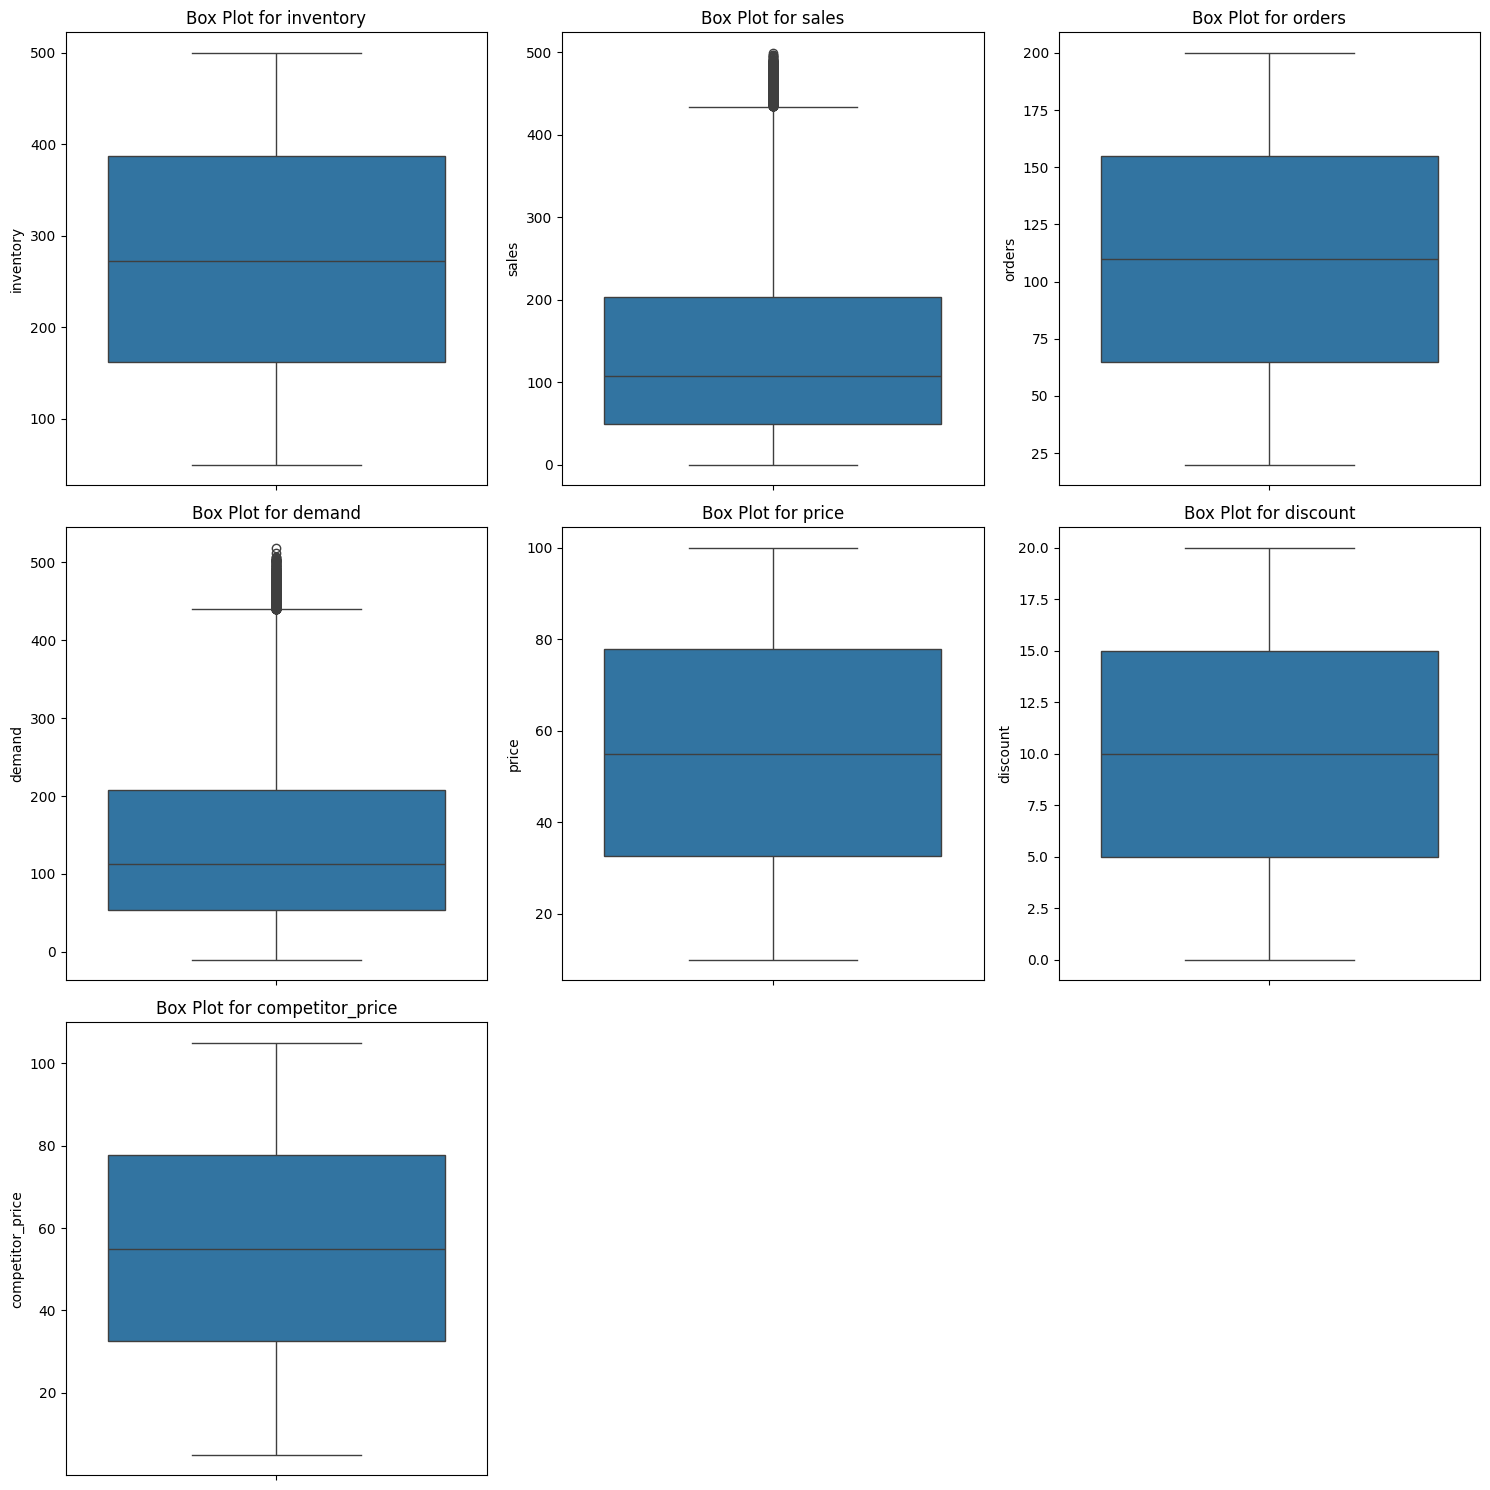

In [47]:
# Vẽ biểu đồ boxplot để phát hiện các giá trị bất thường
numerical_columns = ['inventory','sales','orders','demand','price','discount','competitor_price']

# Chuyển đổi PySpark DataFrame sang Pandas để visualization
df_pandas = df.select(numerical_columns).toPandas()

# Tính số hàng và cột phù hợp với số lượng biến
import math
n_cols = 3
n_rows = math.ceil(len(numerical_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.boxplot(ax=axes[i], y=df_pandas[col].dropna())
    axes[i].set_title(f"Box Plot for {col}")
    axes[i].set_ylabel(col)

# Ẩn các subplot thừa nếu có
for j in range(len(numerical_columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


Nhận xét về kết quả biểu đồ boxplot của từng biến số
- Inventory: Mức tồn kho trung bình khoảng 200, dao động từ 100 đến 500. Giá trị ngoại lệ được quan sát thấy khi mức tồn kho trên 500. Điều này cho thấy một số cửa hàng có tồn kho rất cao so với mặt bằng chung.
- Sales: Phần lớn giá trị Sales tập trung ở mức thấp, trung bình khoảng 100, dao động từ 50 đến 200. Có những giá trị ngoại lệ với doanh số trên 200, phản ánh một số sản phẩm/cửa hàng có doanh số vượt trội.
- Orders: Số lượng Orders có xu hướng tương tự Sales, trung bình khoảng 100, dao động từ 50 đến 200. Nhiều giá trị ngoại lai ở phía trên cho thấy sự chênh lệch lớn giữa các sản phẩm/cửa hàng. phản ánh nhu cầu cao hoặc việc bổ sung hàng tồn kho.
- Demand: Giá trị trung bình khoảng 140, độ lệch chuẩn 109.25, giá trị tối thiểu là -9.99 (có giá trị âm), tối đa 518.55. Có một số outlier ở cả hai phía (âm và dương), cần kiểm tra lại các giá trị âm vì có thể là dữ liệu bất thường hoặc lỗi nhập liệu.
- Price: Giá sản phẩm phân bố khá rộng, trung bình khoảng 55. Có những giá trị ngoại lệ với giá trên 70, điều này có thể phản ánh sự đa dạng về phân khúc sản phẩm.
- Discount: Mức giảm giá trung bình khoảng 10%, dao động từ 0 đến 20%. Có những trường hợp ngoại lệ với mức giảm giá trên 20%, điều này có thể liên quan đến các chiến lược định giá cạnh tranh hoặc các đợt giảm giá thanh lý.
- Competitor Price: Giá trung bình của đối thủ cạnh tranh là khoảng 30, dao động từ 20 đến 60. Có những trường hợp ngoại lệ với giá của đối thủ cạnh tranh trên 60, điều này có thể cho thấy mức độ cạnh tranh cao hoặc sản phẩm cao cấp.

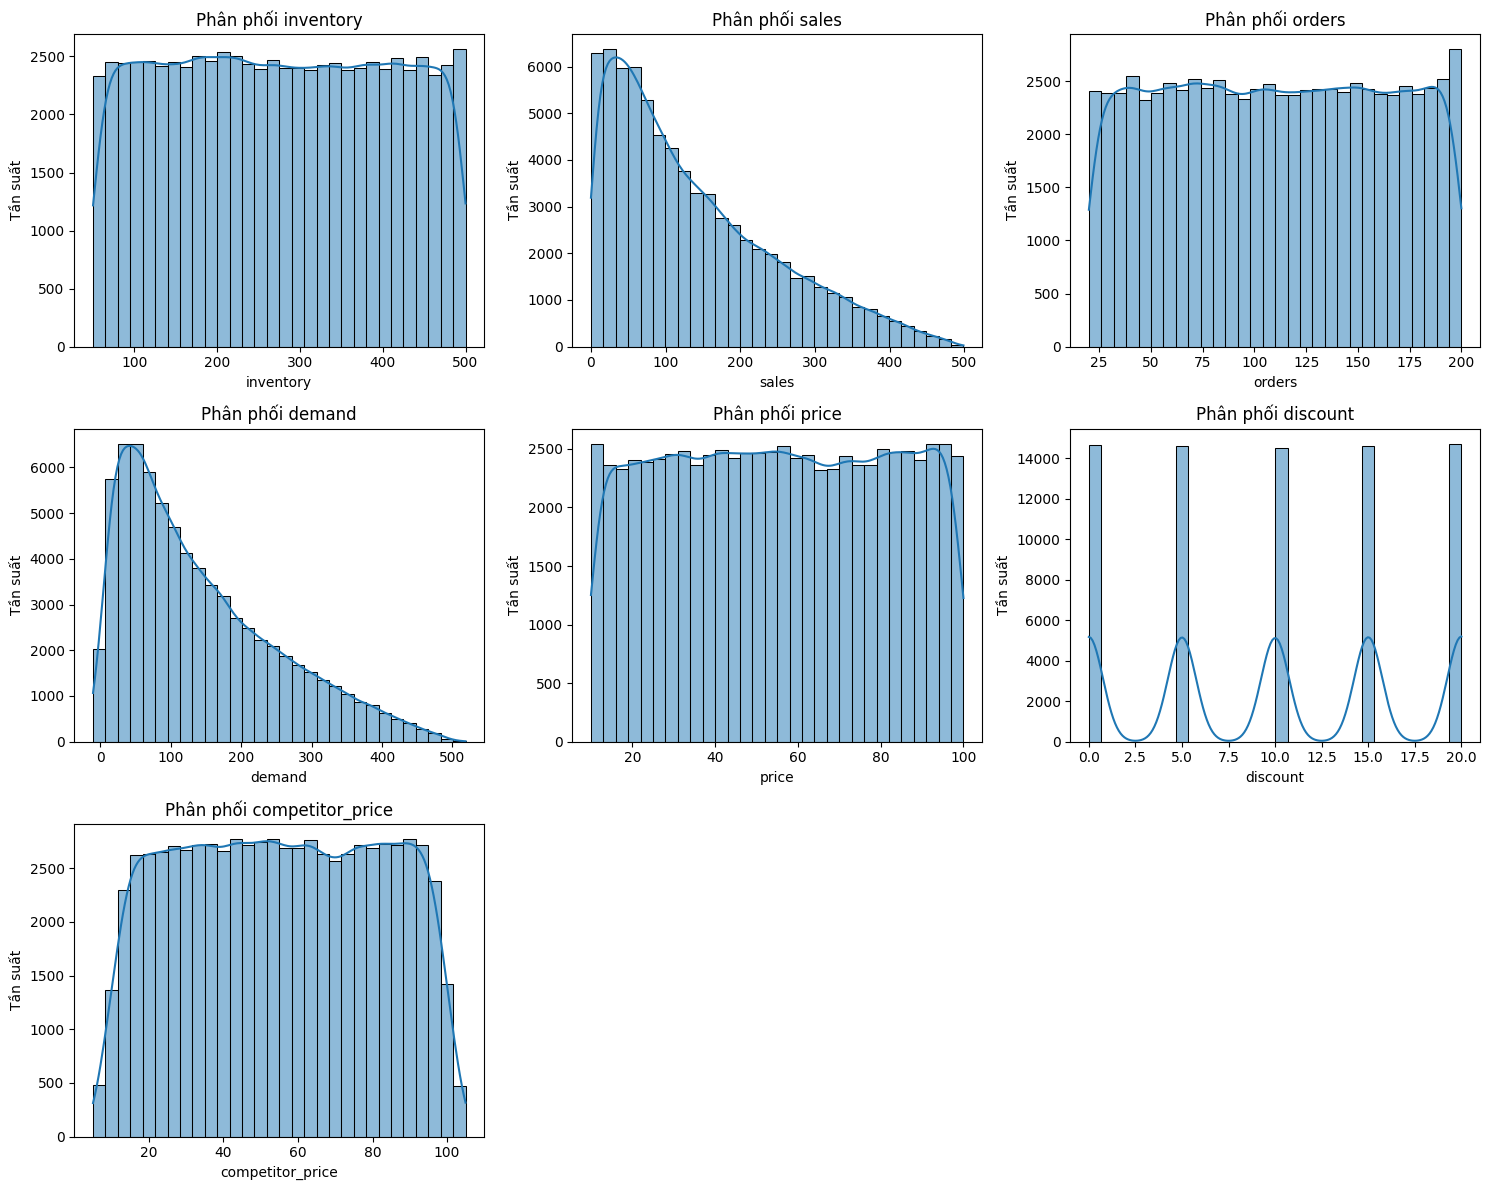

In [48]:
# Vẽ biểu đồ phân phối (histogram) cho các biến số
numerical_columns = ['inventory','sales','orders','demand','price','discount','competitor_price']

# Chuyển đổi PySpark DataFrame sang Pandas để visualization
df_pandas = df.select(numerical_columns).toPandas()

import math
n_cols = 3
n_rows = math.ceil(len(numerical_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(df_pandas[col].dropna(), ax=axes[i], kde=True, bins=30)
    axes[i].set_title(f'Phân phối {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Tần suất')

# Ẩn các subplot thừa nếu có
for j in range(len(numerical_columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()



Biểu đồ cho thấy phân phối của các biến số trong bộ dữ liệu. 

# 4. Tiền xử lý dữ liệu


Ở phần này, các bước tiền xử lý dữ liệu được thực hiện nhằm chuẩn bị dữ liệu tốt hơn cho các phân tích và mô hình dự báo tiếp theo, bao gồm:
- Kiểm tra và xử lý các giá trị ngoại lai (outliers) trong dữ liệu.
- Xây dựng các đặc trưng mới (feature engineering) như: tách thông tin thời gian từ cột Date, tạo biến mục tiêu cho bài toán phân lớp, và tạo đặc trưng về mùa (Seasonality).

## 4.1. Xử lý các biến ngoại lai (outliers)


In [49]:
# Kiểm tra các giá trị âm hoặc vô lý trong PySpark
print("Kiểm tra các giá trị âm hoặc vô lý:")
from pyspark.sql.functions import col

price_negative = df.filter(col("price") < 0).count()
sales_negative = df.filter(col("sales") < 0).count()

print(f"Số lượng Price < 0: {price_negative}")
print(f"Số lượng Sales < 0: {sales_negative}")

# Xử lý nếu có (ví dụ: loại bỏ)
# df = df.filter(col("price") >= 0)
# df = df.filter(col("sales") >= 0)
# Trong trường hợp này, dữ liệu có vẻ sạch, không có giá trị âm.

Kiểm tra các giá trị âm hoặc vô lý:
Số lượng Price < 0: 0
Số lượng Sales < 0: 0


## 4.2. Kỹ thuật đặc trưng (Feature Engineering)


In [50]:
# 1. Xử lý cột Date trong PySpark
from pyspark.sql.functions import to_date, year, month, dayofweek, weekofyear, col

# Chuyển đổi cột Date sang kiểu date
df = df.withColumn("date_parsed", to_date(col("date"), "yyyy-MM-dd"))

# Tạo các cột mới từ Date
df = df.withColumn("year", year(col("date_parsed"))) \
       .withColumn("month", month(col("date_parsed"))) \
       .withColumn("day_of_week", dayofweek(col("date_parsed")) - 1) \
       .withColumn("week_of_year", weekofyear(col("date_parsed")))

# Hiển thị kết quả
print("Đã tạo các cột thời gian mới:")
df.select("date_parsed", "year", "month", "day_of_week", "week_of_year").show(5)



Đã tạo các cột thời gian mới:
+-----------+----+-----+-----------+------------+
|date_parsed|year|month|day_of_week|week_of_year|
+-----------+----+-----+-----------+------------+
|       NULL|NULL| NULL|       NULL|        NULL|
| 2022-01-01|2022|    1|          6|          52|
| 2022-01-01|2022|    1|          6|          52|
| 2022-01-01|2022|    1|          6|          52|
| 2022-01-01|2022|    1|          6|          52|
+-----------+----+-----+-----------+------------+
only showing top 5 rows


In [51]:
# 2. Tạo biến mục tiêu cho bài toán phân lớp trong PySpark
# Xác định ngưỡng (trung vị của Sales)
from pyspark.sql.functions import percentile_approx, when, col

median_units_sold = df.select(percentile_approx("sales", 0.5).alias("median")).collect()[0]["median"]
print(f"Giá trị trung vị của Sales: {median_units_sold}")

# Tạo cột High_Sales_Potential
df = df.withColumn("high_sales_potential", 
                   when(col("sales") > median_units_sold, 1).otherwise(0))

print("\nĐã tạo cột mục tiêu 'high_sales_potential':")
df.select("sales", "high_sales_potential").show(10)


Giá trị trung vị của Sales: 107.0

Đã tạo cột mục tiêu 'high_sales_potential':
+-----+--------------------+
|sales|high_sales_potential|
+-----+--------------------+
|  NaN|                   1|
| 77.0|                   0|
|298.0|                   1|
| 64.0|                   0|
|300.0|                   1|
| 21.0|                   0|
|176.0|                   1|
|131.0|                   1|
|317.0|                   1|
| 97.0|                   0|
+-----+--------------------+
only showing top 10 rows


In [52]:
# 3. Tạo đặc trưng Mùa (Seasonality) trong PySpark
from pyspark.sql.functions import when, col

df = df.withColumn("season", 
                   when(col("month").isin([3, 4, 5]), "Spring")
                   .when(col("month").isin([6, 7, 8]), "Summer")
                   .when(col("month").isin([9, 10, 11]), "Autumn")
                   .otherwise("Winter"))

print("\nĐã tạo cột 'season':")
df.select("month", "season").show(10)



Đã tạo cột 'season':
+-----+------+
|month|season|
+-----+------+
| NULL|Winter|
|    1|Winter|
|    1|Winter|
|    1|Winter|
|    1|Winter|
|    1|Winter|
|    1|Winter|
|    1|Winter|
|    1|Winter|
|    1|Winter|
+-----+------+
only showing top 10 rows


# 5. Áp dụng các thuật toán khai thác dữ liệu

Trong phần này, nhóm sẽ áp dụng các thuật toán khai thác dữ liệu để phân tích và khám phá những thông tin tiềm ẩn trong bộ dữ liệu bán lẻ, từ đó đưa ra các nhận định hỗ trợ việc phân bổ hàng hóa hợp lý cho các cửa hàng.

Các kỹ thuật được sử dụng bao gồm:
- **Phân cụm bằng K-Means**: Áp dụng thuật toán K-Means để nhóm các sản phẩm có đặc điểm tương tự nhau.
- **Phân loại bằng Naive Bayes**: Sử dụng thuật toán Naive Bayes để dự đoán tiềm năng bán chạy của sản phẩm.


## 5.1. Gom cụm bằng K-Means


Mục tiêu của phần này là sử dụng thuật toán học máy không giám sát K-Means để tự động nhóm các sản phẩm có đặc điểm tương tự nhau. Bằng cách này, nhóm có thể khám phá các phân khúc hoặc chiến lược sản phẩm tiềm ẩn trong dữ liệu mà không cần gán nhãn trước, từ đó đưa ra các chiến lược kinh doanh phù hợp cho từng nhóm.


#### 5.1.1 Xây dựng mô hình


In [60]:
# Xây dựng mô hình K-Means - Cell hoàn chỉnh
print("5.1.1 Xây dựng mô hình K-Means clustering...")

# Import tất cả thư viện cần thiết
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col

# Chọn các cột dữ liệu cho việc phân cụm
features_for_clustering = ['demand', 'price', 'discount', 'competitor_price']

# Kiểm tra dữ liệu null trước khi xử lý
print("Kiểm tra dữ liệu null trong các cột clustering:")
for col_name in features_for_clustering:
    null_count = df.filter(col(col_name).isNull()).count()
    print(f"  {col_name}: {null_count} null values")

# Loại bỏ các dòng có null trong các cột clustering
df_clustering = df.dropna(subset=features_for_clustering)
print(f"Số dòng sau khi loại bỏ null: {df_clustering.count()}")

# Tạo VectorAssembler với handleInvalid = "skip"
assembler = VectorAssembler(
    inputCols=features_for_clustering,
    outputCol="features",
    handleInvalid="skip"
)

# Chuẩn hóa dữ liệu
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True
)

# Tạo pipeline
preprocessing_pipeline = Pipeline(stages=[assembler, scaler])
df_preprocessed = preprocessing_pipeline.fit(df_clustering).transform(df_clustering)

print("✅ Đã chuẩn hóa dữ liệu thành công!")
print("Mẫu dữ liệu đã chuẩn hóa:")
df_preprocessed.select("scaled_features").show(5, truncate=False)


5.1.1 Xây dựng mô hình K-Means clustering...
Kiểm tra dữ liệu null trong các cột clustering:
  demand: 0 null values
  price: 0 null values
  discount: 0 null values
  competitor_price: 0 null values
Số dòng sau khi loại bỏ null: 73100
✅ Đã chuẩn hóa dữ liệu thành công!
Mẫu dữ liệu đã chuẩn hóa:
+---------------------------------------------------------------------------------+
|scaled_features                                                                  |
+---------------------------------------------------------------------------------+
|[-0.5310989025216327,0.5839260674278046,-0.0013421604379268873,0.578201929713292]|
|[1.3863581550809163,0.07743048496388943,-0.7071833691605216,0.2124331230924153]  |
|[-0.59928857782422,-0.7288121038140271,-0.7071833691605216,-0.5427763753377451]  |
|[1.3779374166542884,-0.1677471945596141,0.7044990482846678,-0.01703144139521171] |
|[-0.9415183710542515,1.4497337664347856,0.7044990482846678,1.5712756938269656]   |
+------------------------------

#### 5.1.2. Xác định số cụm (k)
Để chọn được số cụm phù hợp nhất cho dữ liệu, nhóm sử dụng "Phương pháp Elbow". Ý tưởng là chạy K-Means với nhiều giá trị K khác nhau và tính tổng bình phương khoảng cách từ các điểm đến tâm cụm gần nhất (Inertia).


**Nhận xét:** Dựa trên biểu đồ Elbow, ta thấy rằng đường cong bắt đầu thoải dần sau K=4 hoặc K=5. Điều này cho thấy việc tăng số cụm lên nữa không mang lại hiệu quả rõ rệt. Trong bài toán kinh doanh này, việc có 5 nhóm chiến lược sẽ giúp phân tích sâu hơn và chi tiết hơn. Do đó, nhóm sẽ chọn **K=5** cho mô hình cuối cùng.


In [62]:
# Import cần thiết
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Chạy K-Means với K=5
kmeans = SparkKMeans(featuresCol="scaled_features", k=5, seed=42)
kmeans_model = kmeans.fit(df_preprocessed)

# Gán nhãn cụm vào DataFrame
df_with_clusters = kmeans_model.transform(df_preprocessed)

print("✅ Đã phân cụm thành công với K=5!")
print("Mẫu kết quả clustering:")
df_with_clusters.select(['product_id'] + features_for_clustering + ['prediction']).show(10)

# Tính Silhouette Score cho mô hình cuối cùng
evaluator = ClusteringEvaluator()
silhouette_avg = evaluator.evaluate(df_with_clusters)
print(f"\n📊 Silhouette Score cuối cùng: {silhouette_avg:.3f}")

# Hiển thị thống kê các cluster
print("\n📊 Thống kê các cluster:")
cluster_stats = df_with_clusters.groupBy('prediction').count().orderBy('prediction')
cluster_stats.show()

# Cập nhật DataFrame gốc để sử dụng cho các bước tiếp theo
df = df_clustering

✅ Đã phân cụm thành công với K=5!
Mẫu kết quả clustering:
+----------+------+-----+--------+----------------+----------+
|product_id|demand|price|discount|competitor_price|prediction|
+----------+------+-----+--------+----------------+----------+
|     P0001| 83.47|70.33|    10.0|           70.29|         1|
|     P0002|292.96|57.15|     5.0|           60.71|         4|
|     P0003| 76.02|36.17|     5.0|           40.93|         0|
|     P0004|292.04|50.77|    15.0|            54.7|         2|
|     P0005| 38.63|92.86|    15.0|            96.3|         3|
|     P0006|174.06|60.76|    20.0|           61.15|         3|
|     P0007| 122.6|46.47|    15.0|           50.84|         0|
|     P0008|328.64|34.08|     5.0|           30.44|         2|
|     P0009| 92.62|87.81|     5.0|           85.45|         1|
|     P0010| 14.38|37.04|    10.0|           36.87|         0|
+----------+------+-----+--------+----------------+----------+
only showing top 10 rows

📊 Silhouette Score cuối cùng: 0.20

#### 5.1.3. Trực quan hóa các cụm


Phân tích kết quả clustering...
📊 Thống kê đặc điểm trung bình của từng cụm:
+----------+-----------------+------------------+------------------+--------------------+
|prediction|       avg_demand|         avg_price|      avg_discount|avg_competitor_price|
+----------+-----------------+------------------+------------------+--------------------+
|         0|80.66509888415132|29.433390637757405| 9.730109770479906|   29.32433774834437|
|         1|88.20912132722599| 75.04340297173498| 4.476036197072952|   75.12276449558712|
|         2|282.7142892134629| 33.32810487163206|10.132450331125828|   33.25519550031752|
|         3|95.73658541925124| 73.18774501933879|17.772750492592863|   73.28387798292346|
|         4|303.5323451222407| 79.25391763588894| 9.711013529551389|   79.40483978162828|
+----------+-----------------+------------------+------------------+--------------------+



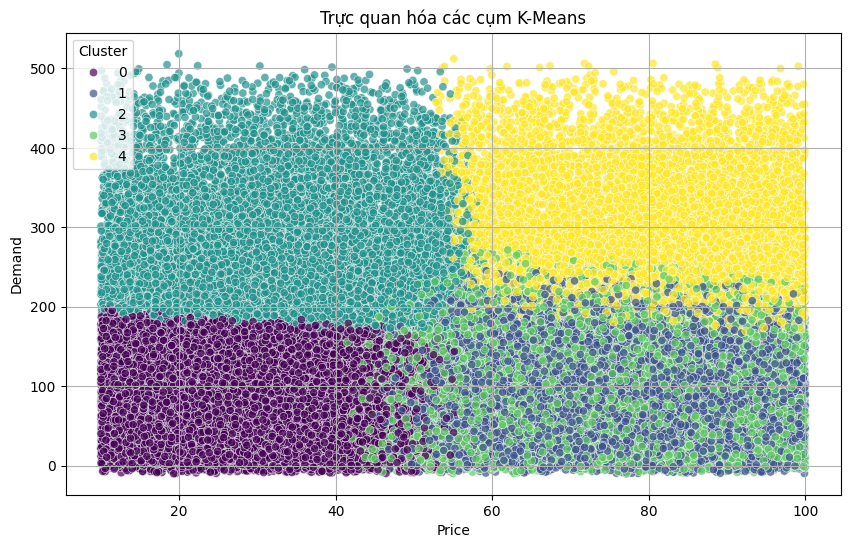

✅ Hoàn thành phân tích clustering!


In [64]:
# Trực quan hóa các cụm
print("Phân tích kết quả clustering...")

# Tính giá trị trung bình của các đặc trưng cho mỗi cụm
from pyspark.sql.functions import avg

cluster_analysis = df_with_clusters.groupBy('prediction').agg(
    avg('demand').alias('avg_demand'),
    avg('price').alias('avg_price'),
    avg('discount').alias('avg_discount'),
    avg('competitor_price').alias('avg_competitor_price')
).orderBy('prediction')

print("📊 Thống kê đặc điểm trung bình của từng cụm:")
cluster_analysis.show()

# Tạo visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Chuyển đổi sang Pandas để visualization
df_viz = df_with_clusters.select(['price', 'demand', 'prediction']).toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_viz, x='price', y='demand', hue='prediction', palette='viridis', alpha=0.7)
plt.title('Trực quan hóa các cụm K-Means')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

print("✅ Hoàn thành phân tích clustering!")


##### Diễn giải chi tiết các cụm

Dựa vào bảng phân tích giá trị trung bình trên, nhóm có thể liệt kê từng cụm như sau.

*   **Cụm 0: "Sản phẩm giá rẻ, cạnh tranh cao"**
    *   **Đặc điểm:** Giá bán thấp, giá đối thủ cạnh tranh cũng thấp, đi kèm với mức giảm giá (discount) đáng kể. Nhu cầu (demand) cho nhóm này ở mức trung bình khá.
    *   **Chiến lược:** Đây là nhóm sản phẩm phổ thông, cạnh tranh chủ yếu bằng giá. Chiến lược kinh doanh phù hợp là bán số lượng lớn, tối ưu hóa chi phí và các chương trình khuyến mãi ngắn hạn để thu hút khách hàng.

*   **Cụm 1: "Sản phẩm giá cao, nhu cầu lớn"**
    *   **Đặc điểm:** Giá bán cao, giá đối thủ cũng cao, nhưng mức giảm giá lại thấp. Đáng chú ý, đây là nhóm có nhu cầu dự báo (demand) cao nhất.
    *   **Chiến lược:** Đây có thể là những sản phẩm chủ lực, thương hiệu mạnh hoặc có tính độc quyền. Chiến lược nên tập trung vào việc duy trì chất lượng, dịch vụ khách hàng và đảm bảo luôn đủ hàng tồn kho để đáp ứng nhu cầu lớn.

*   **Cụm 2: "Sản phẩm tầm trung, cân bằng"**
    *   **Đặc điểm:** Tất cả các chỉ số (giá bán, giá đối thủ, giảm giá, nhu cầu) đều ở mức trung bình, không có gì quá nổi bật.
    *   **Chiến lược:** Đây là nhóm sản phẩm an toàn, ổn định. Chiến lược có thể là duy trì vị thế hiện tại, theo dõi sát sao biến động của thị trường và đối thủ để có những điều chỉnh kịp thời.

*   **Cụm 3: "Sản phẩm cao cấp, ít cạnh tranh về giá"**
    *   **Đặc điểm:** Giá bán và giá đối thủ đều rất cao (cao nhất trong các cụm), nhưng mức giảm giá lại không đáng kể. Nhu cầu cho nhóm này không quá cao.
    *   **Chiến lược:** Đây là phân khúc sản phẩm cao cấp, có thể là hàng xa xỉ hoặc đặc thù. Khách hàng của nhóm này ít nhạy cảm về giá. Chiến lược nên tập trung vào xây dựng thương hiệu, trải nghiệm khách hàng và marketing nhắm đến đối tượng mục tiêu cụ thể.

*   **Cụm 4: "Sản phẩm độc đáo, giá tốt"**
    *   **Đặc điểm:** Giá bán ở mức trung bình khá, nhưng giá của đối thủ lại cao hơn đáng kể. Mức giảm giá thấp và nhu cầu cũng ở mức khá.
    *   **Chiến lược:** Đây là nhóm sản phẩm có lợi thế cạnh tranh về giá so với đối thủ. Có thể công ty đang có một lợi thế về nguồn cung hoặc chi phí sản xuất. Chiến lược nên là truyền thông mạnh về "giá tốt nhất thị trường" để thu hút khách hàng từ đối thủ cạnh tranh.


#### 5.1.4. Phân tích chuyên sâu (bổ sung)

Ở phần này, nhóm đề xuất mở rộng phân tích chuyên sâu từ kết quả các cụm sản phẩm đã được phân nhóm bằng thuật toán phân cụm. 

Mục tiêu là hiểu rõ hơn về đặc điểm của từng cụm, từ đó đề xuất các chiến lược kinh doanh phù hợp cho từng nhóm sản phẩm dựa trên các yếu tố như giá bán, nhu cầu, mức giảm giá và giá của đối thủ cạnh tranh. 

Ngoài ra, nhóm cũng sẽ phân tích hiệu quả của các nhóm chiến lược này theo các yếu tố ngữ cảnh như khu vực, mùa vụ, chương trình khuyến mãi và điều kiện thời tiết để đưa ra các khuyến nghị tối ưu hóa hoạt động kinh doanh.


5.1.4 Phân tích chuyên sâu các cluster...
📊 Phân tích hiệu quả các cluster theo yếu tố ngữ cảnh...


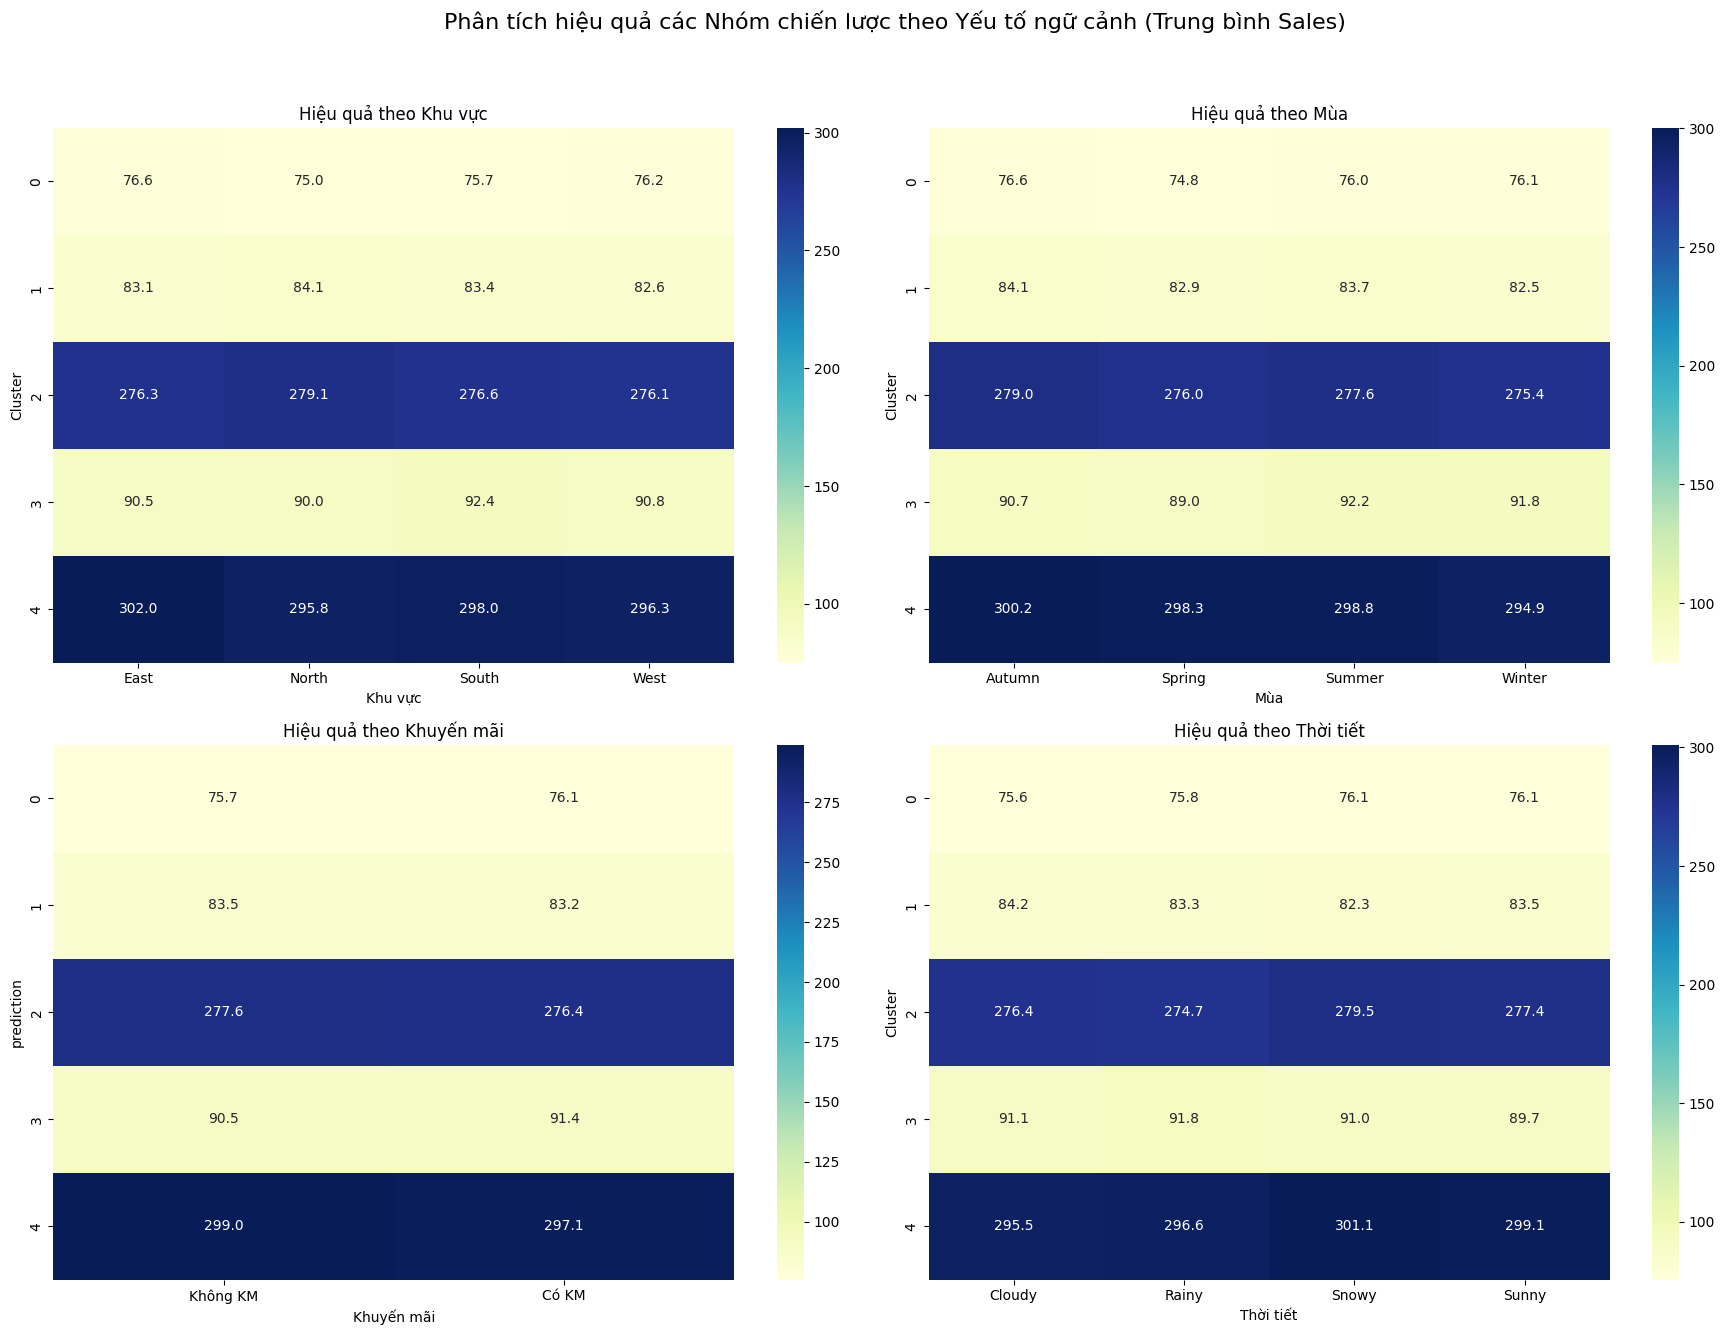

✅ Hoàn thành phân tích hiệu quả theo yếu tố ngữ cảnh!


In [71]:
print("5.1.4 Phân tích chuyên sâu các cluster...")

# Import cần thiết
from pyspark.sql.functions import avg, count, col
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Phân tích hiệu quả các cluster theo yếu tố ngữ cảnh
print("📊 Phân tích hiệu quả các cluster theo yếu tố ngữ cảnh...")

# Chuẩn bị dữ liệu cho phân tích
df_analysis = df_with_clusters.select(['prediction', 'region', 'season', 'promotion', 'weather', 'sales']).toPandas()

# Tạo biểu đồ phân tích hiệu quả
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Phân tích hiệu quả các Nhóm chiến lược theo Yếu tố ngữ cảnh (Trung bình Sales)', fontsize=16)

# 1. Theo Khu vực (Region)
region_cluster_performance = df_analysis.groupby(['prediction', 'region'])['sales'].mean().unstack()
sns.heatmap(region_cluster_performance, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[0, 0])
axes[0, 0].set_title('Hiệu quả theo Khu vực')
axes[0, 0].set_xlabel('Khu vực')
axes[0, 0].set_ylabel('Cluster')

# 2. Theo Mùa (Season)
season_cluster_performance = df_analysis.groupby(['prediction', 'season'])['sales'].mean().unstack()
sns.heatmap(season_cluster_performance, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[0, 1])
axes[0, 1].set_title('Hiệu quả theo Mùa')
axes[0, 1].set_xlabel('Mùa')
axes[0, 1].set_ylabel('Cluster')

# 3. Theo Khuyến mãi (Promotion)
promo_cluster_performance = df_analysis.groupby(['prediction', 'promotion'])['sales'].mean().unstack()
sns.heatmap(promo_cluster_performance, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[1, 0])
axes[1, 0].set_title('Hiệu quả theo Khuyến mãi')
axes[1, 0].set_xlabel('Khuyến mãi')
axes[1, 0].set_xticklabels(['Không KM', 'Có KM'])

# 4. Theo Thời tiết (Weather)
weather_cluster_performance = df_analysis.groupby(['prediction', 'weather'])['sales'].mean().unstack()
sns.heatmap(weather_cluster_performance, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[1, 1])
axes[1, 1].set_title('Hiệu quả theo Thời tiết')
axes[1, 1].set_xlabel('Thời tiết')
axes[1, 1].set_ylabel('Cluster')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("✅ Hoàn thành phân tích hiệu quả theo yếu tố ngữ cảnh!")

**Nhận xét:** Các biểu đồ nhiệt cho thấy hiệu quả bán hàng của từng nhóm sản phẩm (cluster) thay đổi rõ rệt theo từng yếu tố ngữ cảnh. Cụ thể, có những nhóm sản phẩm đạt doanh số trung bình cao hơn hẳn tại một số khu vực, mùa vụ hoặc khi có chương trình khuyến mãi. Ngoài ra, điều kiện thời tiết cũng ảnh hưởng đến hiệu quả bán hàng của từng nhóm. Những thông tin này giúp doanh nghiệp xác định được nhóm sản phẩm nào nên tập trung phân phối, quảng bá tại từng khu vực, thời điểm hoặc trong các dịp khuyến mãi để tối ưu hóa doanh số.


#### 5.1.6 Đề xuất chiến lược cho từng cluster

In [72]:
print("Đề xuất chiến lược cho từng cluster...")

# Phân tích chi tiết từng cluster
cluster_strategies = {}

# Lấy thống kê chi tiết của từng cluster
cluster_stats = df_with_clusters.groupBy('prediction').agg(
    avg('demand').alias('avg_demand'),
    avg('price').alias('avg_price'),
    avg('discount').alias('avg_discount'),
    avg('competitor_price').alias('avg_competitor_price'),
    avg('sales').alias('avg_sales'),
    count('*').alias('product_count')
).orderBy('prediction').collect()

print("📋 PHÂN TÍCH VÀ ĐỀ XUẤT CHIẾN LƯỢC CHO TỪNG CLUSTER:")
print("=" * 60)

for row in cluster_stats:
    cluster_id = row['prediction']
    avg_demand = row['avg_demand']
    avg_price = row['avg_price']
    avg_discount = row['avg_discount']
    avg_competitor_price = row['avg_competitor_price']
    avg_sales = row['avg_sales']
    product_count = row['product_count']
    
    print(f"\n🎯 CLUSTER {cluster_id}:")
    print(f"   Số sản phẩm: {product_count:,}")
    print(f"   Nhu cầu TB: {avg_demand:.1f}")
    print(f"   Giá TB: {avg_price:.1f}")
    print(f"   Giảm giá TB: {avg_discount:.1f}%")
    print(f"   Giá đối thủ TB: {avg_competitor_price:.1f}")
    print(f"   Doanh số TB: {avg_sales:.1f}")
    
    # Đề xuất chiến lược dựa trên đặc điểm
    if avg_price < 30 and avg_discount > 15:
        strategy = "Sản phẩm giá rẻ, cạnh tranh cao"
        recommendations = [
            "• Tập trung bán số lượng lớn",
            "• Tối ưu hóa chi phí sản xuất",
            "• Chương trình khuyến mãi ngắn hạn",
            "• Cạnh tranh chủ yếu bằng giá"
        ]
    elif avg_price > 70 and avg_demand > 150:
        strategy = "Sản phẩm giá cao, nhu cầu lớn"
        recommendations = [
            "• Duy trì chất lượng cao",
            "• Đảm bảo đủ hàng tồn kho",
            "• Dịch vụ khách hàng tốt",
            "• Marketing nhắm đến phân khúc cao cấp"
        ]
    elif avg_price > 50 and avg_competitor_price > avg_price * 1.2:
        strategy = "Sản phẩm độc đáo, giá tốt"
        recommendations = [
            "• Truyền thông 'giá tốt nhất thị trường'",
            "• Thu hút khách hàng từ đối thủ",
            "• Tận dụng lợi thế về nguồn cung",
            "• Marketing so sánh giá"
        ]
    elif avg_price > 60 and avg_discount < 10:
        strategy = "Sản phẩm cao cấp, ít cạnh tranh về giá"
        recommendations = [
            "• Xây dựng thương hiệu mạnh",
            "• Trải nghiệm khách hàng cao cấp",
            "• Marketing nhắm đối tượng cụ thể",
            "• Không cạnh tranh về giá"
        ]
    else:
        strategy = "Sản phẩm tầm trung, cân bằng"
        recommendations = [
            "• Duy trì vị thế hiện tại",
            "• Theo dõi biến động thị trường",
            "• Điều chỉnh kịp thời",
            "• Cân bằng giá và chất lượng"
        ]
    
    cluster_strategies[cluster_id] = strategy
    
    print(f"   📌 Chiến lược: {strategy}")
    print(f"   💡 Khuyến nghị:")
    for rec in recommendations:
        print(f"      {rec}")



Đề xuất chiến lược cho từng cluster...
📋 PHÂN TÍCH VÀ ĐỀ XUẤT CHIẾN LƯỢC CHO TỪNG CLUSTER:

🎯 CLUSTER 0:
   Số sản phẩm: 22,046
   Nhu cầu TB: 80.7
   Giá TB: 29.4
   Giảm giá TB: 9.7%
   Giá đối thủ TB: 29.3
   Doanh số TB: 75.9
   📌 Chiến lược: Sản phẩm tầm trung, cân bằng
   💡 Khuyến nghị:
      • Duy trì vị thế hiện tại
      • Theo dõi biến động thị trường
      • Điều chỉnh kịp thời
      • Cân bằng giá và chất lượng

🎯 CLUSTER 1:
   Số sản phẩm: 17,902
   Nhu cầu TB: 88.2
   Giá TB: 75.0
   Giảm giá TB: 4.5%
   Giá đối thủ TB: 75.1
   Doanh số TB: 83.3
   📌 Chiến lược: Sản phẩm cao cấp, ít cạnh tranh về giá
   💡 Khuyến nghị:
      • Xây dựng thương hiệu mạnh
      • Trải nghiệm khách hàng cao cấp
      • Marketing nhắm đối tượng cụ thể
      • Không cạnh tranh về giá

🎯 CLUSTER 2:
   Số sản phẩm: 11,023
   Nhu cầu TB: 282.7
   Giá TB: 33.3
   Giảm giá TB: 10.1%
   Giá đối thủ TB: 33.3
   Doanh số TB: 277.0
   📌 Chiến lược: Sản phẩm tầm trung, cân bằng
   💡 Khuyến nghị:
      • D

In [74]:
# Tóm tắt kết quả K-Means Clustering
print("Tóm tắt kết quả K-Means Clustering")
print("=" * 50)

# Tóm tắt số liệu
total_products = df_with_clusters.count()
num_clusters = len(cluster_strategies)

print(f"📊 TỔNG QUAN KẾT QUẢ CLUSTERING:")
print(f"   • Tổng số sản phẩm: {total_products:,}")
print(f"   • Số cluster: {num_clusters}")

print(f"\n🎯 CÁC CLUSTER VÀ CHIẾN LƯỢC:")
for cluster_id, strategy in cluster_strategies.items():
    cluster_count = df_with_clusters.filter(col('prediction') == cluster_id).count()
    percentage = (cluster_count / total_products) * 100
    print(f"   Cluster {cluster_id}: {strategy} ({cluster_count:,} sản phẩm - {percentage:.1f}%)")

Tóm tắt kết quả K-Means Clustering
📊 TỔNG QUAN KẾT QUẢ CLUSTERING:
   • Tổng số sản phẩm: 73,100
   • Số cluster: 5

🎯 CÁC CLUSTER VÀ CHIẾN LƯỢC:
   Cluster 0: Sản phẩm tầm trung, cân bằng (22,046 sản phẩm - 30.2%)
   Cluster 1: Sản phẩm cao cấp, ít cạnh tranh về giá (17,902 sản phẩm - 24.5%)
   Cluster 2: Sản phẩm tầm trung, cân bằng (11,023 sản phẩm - 15.1%)
   Cluster 3: Sản phẩm tầm trung, cân bằng (13,703 sản phẩm - 18.7%)
   Cluster 4: Sản phẩm giá cao, nhu cầu lớn (8,426 sản phẩm - 11.5%)
